In [6]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import rotate
import aesara

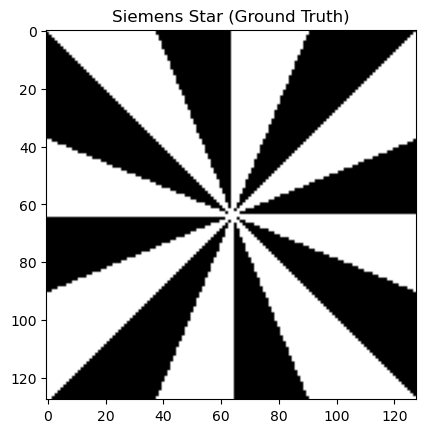

In [3]:
def generate_siemens_star(size, n_spokes):
    star = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            angle = np.arctan2(i - center, j - center)
            spoke = int((angle / np.pi + 1) * n_spokes / 2) % n_spokes
            star[i, j] = 1 if spoke % 2 == 0 else 0
    return star

size = 128
n_spokes = 16
I_true = generate_siemens_star(size, n_spokes)
plt.imshow(I_true, cmap='gray')
plt.title('Siemens Star (Ground Truth)')
plt.show()

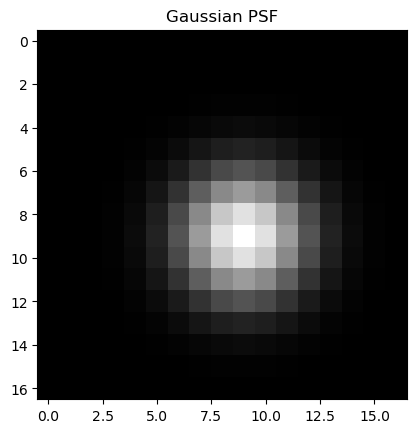

In [6]:
def gaussian_psf(size, sigma):
    x = np.arange(-size // 2, size // 2)
    y = np.arange(-size // 2, size // 2)
    x, y = np.meshgrid(x, y)
    psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    psf /= psf.sum()
    return psf

sigma = 2.0
psf = gaussian_psf(17, sigma)
plt.imshow(psf, cmap='gray')
plt.title('Gaussian PSF')
plt.show()

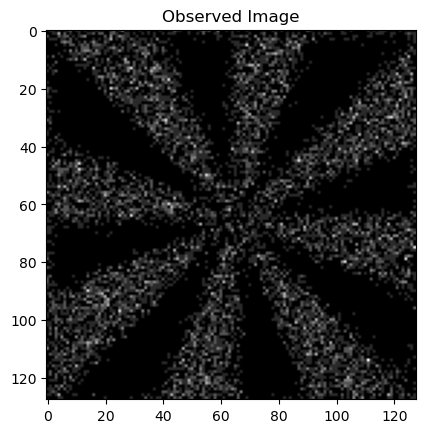

In [9]:
I_convolved = convolve2d(I_true, psf, mode='same', boundary='wrap')
I_observed = np.random.poisson(I_convolved)
plt.imshow(I_observed, cmap='gray')
plt.title('Observed Image')
plt.show()

In [ ]:
import aesara.tensor as at
import pymc as pm
import numpy as np

with pm.Model() as model:
    # 定义 ground truth 图像的先验分布
    I_true_prior = pm.Uniform('I_true_prior', lower=0, upper=1, shape=I_true.shape)
    
    # 使用 aesara 的卷积操作
    # 注意: 需要先反转 PSF 核（在卷积而非互相关定义中）
    psf_flipped = np.flip(np.flip(psf, axis=0), axis=1)
    
    # 使用 Aesara 的卷积操作
    I_convolved_model = pm.Deterministic(
        'I_convolved',
        at.signal.conv2d(
            at.reshape(I_true_prior, (1, 1, *I_true.shape)),
            at.reshape(psf_flipped, (1, 1, *psf_flipped.shape)),
            border_mode='half'
        )[0, 0]  # 移除批次和通道维度
    )
    
    # 泊松噪声模型
    I_observed_model = pm.Poisson('I_observed', mu=I_convolved_model, observed=I_observed)
    
    # 采样
    trace = pm.sample(1000, tune=1000, cores=1)

ModuleNotFoundError: No module named 'pytensor.tensor.nnet'

In [ ]:
pm.plot_trace(trace)
plt.show()

# 获取后验分布的均值
I_true_posterior_mean = trace['I_true_prior'].mean(axis=0)
plt.imshow(I_true_posterior_mean, cmap='gray')
plt.title('Posterior Mean of Ground Truth')
plt.show()